In [1]:
import os
import pandas as pd

# Read the datasets
df_input = pd.read_csv('dataset/combined_dataset/all_datasets.csv')


In [2]:
df_input.head()

,unique_id,customer_id,local_guide,date_year,text,store_name,company_name,text_response
0,0,394,True,2023,This store has cool merchandise. Very stylish ...,Berlin Store Originals,adidas,NaN
1,1,604,True,2022,very friendly kind people. they helped me and ...,Berlin Store Originals,adidas,NaN
2,2,528,True,2023,Was keen to visit hoping to find some German b...,Berlin Store Originals,adidas,NaN
3,3,591,True,2024,Lots of different choices ive never seen befor...,Berlin Store Originals,adidas,NaN
4,4,336,False,2023,The person on a cash register didn’t answer my...,Berlin Store Originals,adidas,NaN


In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda')

CUDA is available. Training on GPU...


In [4]:
# Calculate sentiment using transformers
# Convert the df into a dataset
from datasets import Dataset
from transformers import pipeline

dataset = Dataset.from_pandas(df_input)

# Load the sentiment analysis model
sentiment_analysis = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    device=0 if torch.cuda.is_available() else -1,
)

def apply_sentiment(batch):
    # Assuming 'text' is the column that contains the text you want to analyze
    results = sentiment_analysis(batch['text'])
    # We return the results as new columns
    return {
        'label_name': [result['label'] for result in results],
        'confidence_score': [result['score'] for result in results],
    }

# Apply the function to the 'text' column and get the result as new columns
dataset = dataset.map(apply_sentiment, batched=True, batch_size=256)



Map:   0%|          | 0/6843 [00:00<?, ? examples/s]

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\solar_fg2i0nh\anaconda3\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\solar_fg2i0nh\anaconda3\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\solar_fg2i0nh\anaconda3\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\solar_fg2i0nh\anaconda3\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\solar_fg2i0nh\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\solar_

In [6]:
# Convert dataset back to pandas DataFrame
df_sentiment = dataset.data.to_pandas()

# Add column label_id (-1 for negative, 0 for neutral, 1 for positive)

label_dict = {
    'negative': -1,
    'neutral': 0,
    'positive': 1,
}

df_sentiment['label_id'] = df_sentiment['label_name'].apply(lambda x: label_dict[x])
# Save the sentiment dataset
df_sentiment.to_csv('dataset/combined_dataset/sentiment_dataset.csv', index=False)

df_sentiment.head()


,unique_id,customer_id,local_guide,date_year,text,store_name,company_name,text_response,label_name,confidence_score,label_id
0,0,394,True,2023,This store has cool merchandise. Very stylish ...,Berlin Store Originals,adidas,None,positive,0.963334,1
1,1,604,True,2022,very friendly kind people. they helped me and ...,Berlin Store Originals,adidas,None,positive,0.883232,1
2,2,528,True,2023,Was keen to visit hoping to find some German b...,Berlin Store Originals,adidas,None,neutral,0.454984,0
3,3,591,True,2024,Lots of different choices ive never seen befor...,Berlin Store Originals,adidas,None,positive,0.404322,1
4,4,336,False,2023,The person on a cash register didn’t answer my...,Berlin Store Originals,adidas,None,neutral,0.466237,0


,unique_id,customer_id,local_guide,date_year,text,store_name,company_name,text_response,label_name,confidence_score,label_id
0,0,394,True,2023,This store has cool merchandise. Very stylish ...,Berlin Store Originals,adidas,None,positive,0.963334,1
1,1,604,True,2022,very friendly kind people. they helped me and ...,Berlin Store Originals,adidas,None,positive,0.883232,1
2,2,528,True,2023,Was keen to visit hoping to find some German b...,Berlin Store Originals,adidas,None,neutral,0.454984,0
3,3,591,True,2024,Lots of different choices ive never seen befor...,Berlin Store Originals,adidas,None,positive,0.404322,1
4,4,336,False,2023,The person on a cash register didn’t answer my...,Berlin Store Originals,adidas,None,neutral,0.466237,0


In [8]:
# Make a dataframe with only adidas reviews
df_adidas = df_sentiment[df_sentiment['company_name'] == 'adidas']

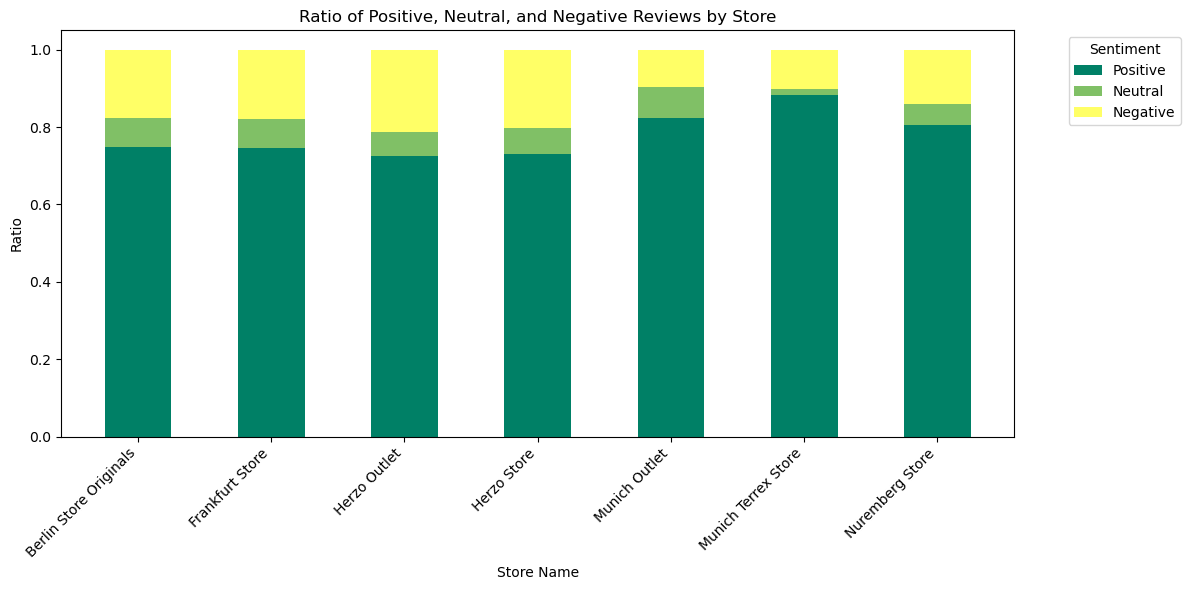

In [9]:
# Make one barchart where each store_name has 1 bar for the ratio of positive, neutral, and negative reviews
# Plot with matplotlib and use cmap to color the bars

import matplotlib.pyplot as plt
import numpy as np

# Group by store and label_name
df_grouped = df_adidas.groupby(['store_name', 'label_name']).size().unstack(fill_value=0)

# Calculate the ratio of each label_name
df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)


# Colors from the 'summer' colormap
colors = plt.cm.summer(np.linspace(0, 1, 3))
colors = colors[::-1]  # Reverse the colors to match the sentiment order (negative, neutral, positive)

plt.figure(figsize=(12, 6))
barWidth = 0.50
r = np.arange(len(df_grouped.index))

# Adjusting the plot commands with correct color mapping and edgecolor
plt.bar(r, df_grouped['positive'], color=colors[2], width=barWidth, edgecolor='none', label='Positive')
plt.bar(r, df_grouped['neutral'], bottom=df_grouped['positive'], color=colors[1], width=barWidth, edgecolor='none', label='Neutral')
plt.bar(r, df_grouped['negative'], bottom=df_grouped['positive'] + df_grouped['neutral'], color=colors[0], width=barWidth, edgecolor='none', label='Negative')

plt.xticks(r, df_grouped.index, rotation=45, ha='right')
plt.title('Ratio of Positive, Neutral, and Negative Reviews by Store')
plt.xlabel('Store Name')
plt.ylabel('Ratio')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


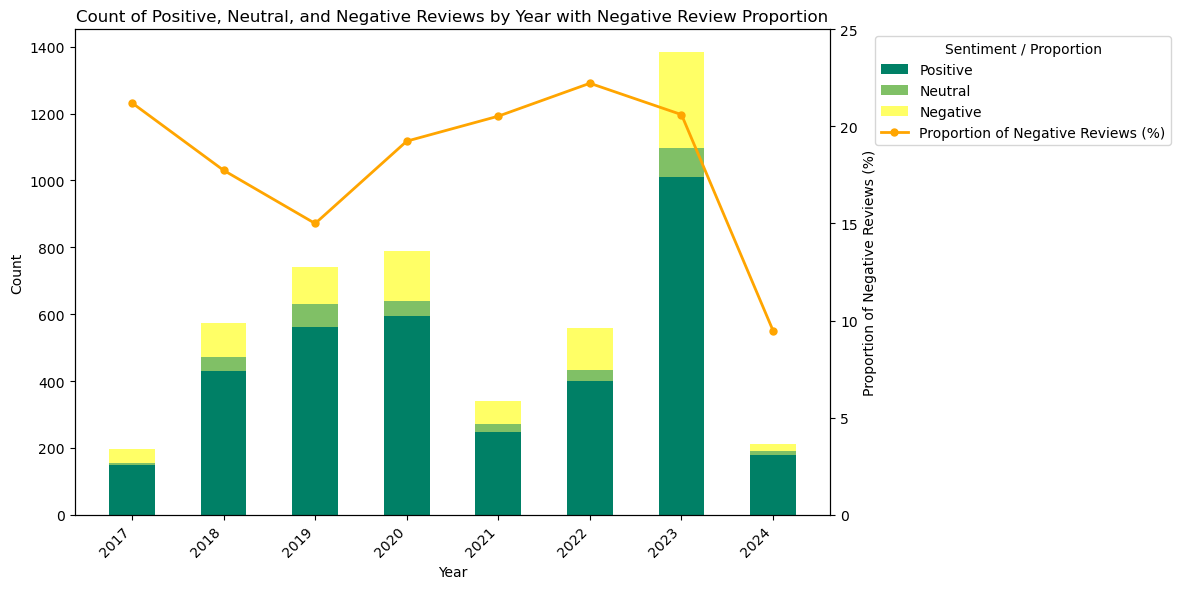

In [39]:
# Make the same barchart, but instead over store_name do it over date_year

# Group by date_year and label_name
df_grouped = df_adidas.groupby(['date_year', 'label_name']).size().unstack(fill_value=0)
df_grouped = df_grouped[df_grouped.index.get_level_values('date_year') >= 2017]

# Calculate the ratio of each label_name
#df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
barWidth = 0.50

r = np.arange(len(df_grouped.index))
# Colors from the 'summer' colormap
colors = plt.cm.summer(np.linspace(0, 1, 3))

#colors = colors[::-1]  # Reverse the colors to match the sentiment order (negative, neutral, positive)

# Adjusting the plot commands with correct color mapping and edgecolor
plt.bar(r, df_grouped['positive'], color=colors[0], width=barWidth, edgecolor='none', label='Positive')
plt.bar(r, df_grouped['neutral'], bottom=df_grouped['positive'], color=colors[1], width=barWidth, edgecolor='none', label='Neutral')
plt.bar(r, df_grouped['negative'], bottom=df_grouped['positive'] + df_grouped['neutral'], color=colors[2], width=barWidth, edgecolor='none', label='Negative')

plt.xticks(r, df_grouped.index, rotation=45, ha='right')
# plt.title('Ratio of Positive, Neutral, and Negative Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Count')
# plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()




# Recalculate the ratio of each label_name
df_grouped_ratio = df_grouped.div(df_grouped.sum(axis=1), axis=0)

# Calculate the proportion of negative reviews in percentage
negative_proportion = df_grouped_ratio['negative'] * 100

# Get the current axes and create a secondary y-axis
axes = plt.gca()
sec_axes = axes.twinx()

# Plotting the proportion of negative reviews on the secondary y-axis
sec_axes.plot(r, negative_proportion, color='orange', marker='o', linestyle='-', linewidth=2, markersize=5, label='Proportion of Negative Reviews (%)')

# Set the limit for the secondary y-axis to 0-30 percent for clarity
sec_axes.set_ylim([0, 25])

# Adding labels and legend to the secondary y-axis
sec_axes.set_ylabel('Proportion of Negative Reviews (%)')

# To create a combined legend for both axes, manually handle the legends
bars_legend = axes.get_legend_handles_labels()
lines_legend = sec_axes.get_legend_handles_labels()
all_handles = bars_legend[0] + lines_legend[0]
all_labels = bars_legend[1] + lines_legend[1]

plt.legend(all_handles, all_labels, title='Sentiment / Proportion', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Count of Positive, Neutral, and Negative Reviews by Year with Negative Review Proportion')
plt.xlabel('Year')
plt.tight_layout()
plt.show()


In [45]:
# In df_review_metadata we have store, num_ratings, num_reviews, and star_rating
# Lets add the number of positive, neutral, and negative reviews to this dataframe per store

df_review_metadata = pd.read_csv('dataset/review_metadata.csv')

# Group by store and label_name
df_grouped = df_sentiment.groupby(['store_name', 'label_name']).size().unstack(fill_value=0)

# Merge the grouped dataframe with df_review_metadata
df_review_metadata = df_review_metadata.merge(df_grouped, left_on='store', right_index=True, how='left')

# Fill NaN values with 0
df_review_metadata.fillna(0, inplace=True)


df_review_metadata

,store,num_ratings,num_reviews,star_rating,negative,neutral,positive
0,Herzo Store,8776,2201,4.2,446,149,1605
1,Herzo Outlet,2365,1091,4.2,230,68,785
2,Nuremberg Store,763,288,4.3,40,16,231
3,Munich Outlet,450,210,4.3,20,17,172
4,Munich Terrex Store,102,68,4.7,7,1,60
5,Frankfurt Store,786,324,4.1,58,24,240
6,Berlin Store Originals,1293,681,4.1,120,51,506
7,Competitor Outlet,6533,2008,4.4,234,102,1661


In [46]:
# reconstruct the sentiment star rating by weighing positive, neutral, and negative reviews
# positive is 5 stars, neutral is 3 stars, and negative is 1 star
# Divide by the total number of reviews to get the average rating 

df_review_metadata['sentiment_star_rating'] = (df_review_metadata['positive'] * 5 + df_review_metadata['neutral'] * 3 + df_review_metadata['negative']) / df_review_metadata['num_reviews']


# calculate correlation between sentiment star rating and star rating
correlation = df_review_metadata['sentiment_star_rating'].corr(df_review_metadata['star_rating'])
print(f'Correlation between sentiment star rating and star rating: {correlation:.2f}')

,store,num_ratings,num_reviews,star_rating,negative,neutral,positive,sentiment_star_rating
0,Herzo Store,8776,2201,4.2,446,149,1605,4.051795
1,Herzo Outlet,2365,1091,4.2,230,68,785,3.995417
2,Nuremberg Store,763,288,4.3,40,16,231,4.315972
3,Munich Outlet,450,210,4.3,20,17,172,4.433333
4,Munich Terrex Store,102,68,4.7,7,1,60,4.558824
5,Frankfurt Store,786,324,4.1,58,24,240,4.104938
6,Berlin Store Originals,1293,681,4.1,120,51,506,4.116006
7,Competitor Outlet,6533,2008,4.4,234,102,1661,4.404880


In [49]:
# calculate correlation between sentiment star rating and star rating
correlation = df_review_metadata['sentiment_star_rating'].corr(df_review_metadata['star_rating'])
print(f'Correlation between sentiment star rating and star rating: {correlation:.2f}')

Correlation between sentiment star rating and star rating: 0.84


In [ ]:
# Save df_review_metadata with sentiment star rating

df_review_metadata.to_csv('dataset/review_metadata_sentiment.csv', index=False)

